In [1]:
import torch
import numpy as np 
from gpytorch.kernels import ScaleKernel
from abc import ABC, abstractmethod
import gpytorch
from gpytorch.kernels import MaternKernel,RBFKernel
import os
import sys
from gpytorch.priors import GammaPrior

# Data path setup
notebook_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(notebook_dir, '../code'))
if src_path not in sys.path:
    sys.path.append(src_path)
from util  import train, eval, plot_gpr_results, memory_dump, fetch_uci_dataset
import sys
from gps import IterativeGaussianProcess,CholeskyGaussianProcess
from plotting import plot_gp_simple,plot_gp_sample,plot_gp_simple_regions


%load_ext autoreload
%autoreload 2
device="cuda:0"
global_dtype=torch.float32
np.random.seed(42)
torch.manual_seed(42)

In [2]:
def generate_data(true_function, train_range=(-3, 3), test_range=(-3, 3), 
                  n_train=100, n_test=100, noise_std=0.1, 
                  device='cuda:0', dtype=torch.float64):
    X_train = torch.linspace(train_range[0], train_range[1], n_train, dtype=dtype, device=device).unsqueeze(-1)
    y_train = true_function(X_train) + noise_std * torch.randn_like(X_train)
    
    X_test = torch.linspace(test_range[0], test_range[1], n_test, dtype=dtype, device=device).unsqueeze(-1)
    y_test = true_function(X_test)  # No noise added to test data
    
    return X_train, y_train.squeeze(), X_test, y_test.squeeze()

def true_function(x):
    return torch.sin(2 * x) + torch.cos(3 * x)
train_x, train_y, test_x, test_y = generate_data(true_function, test_range=(-5,5), dtype=global_dtype)

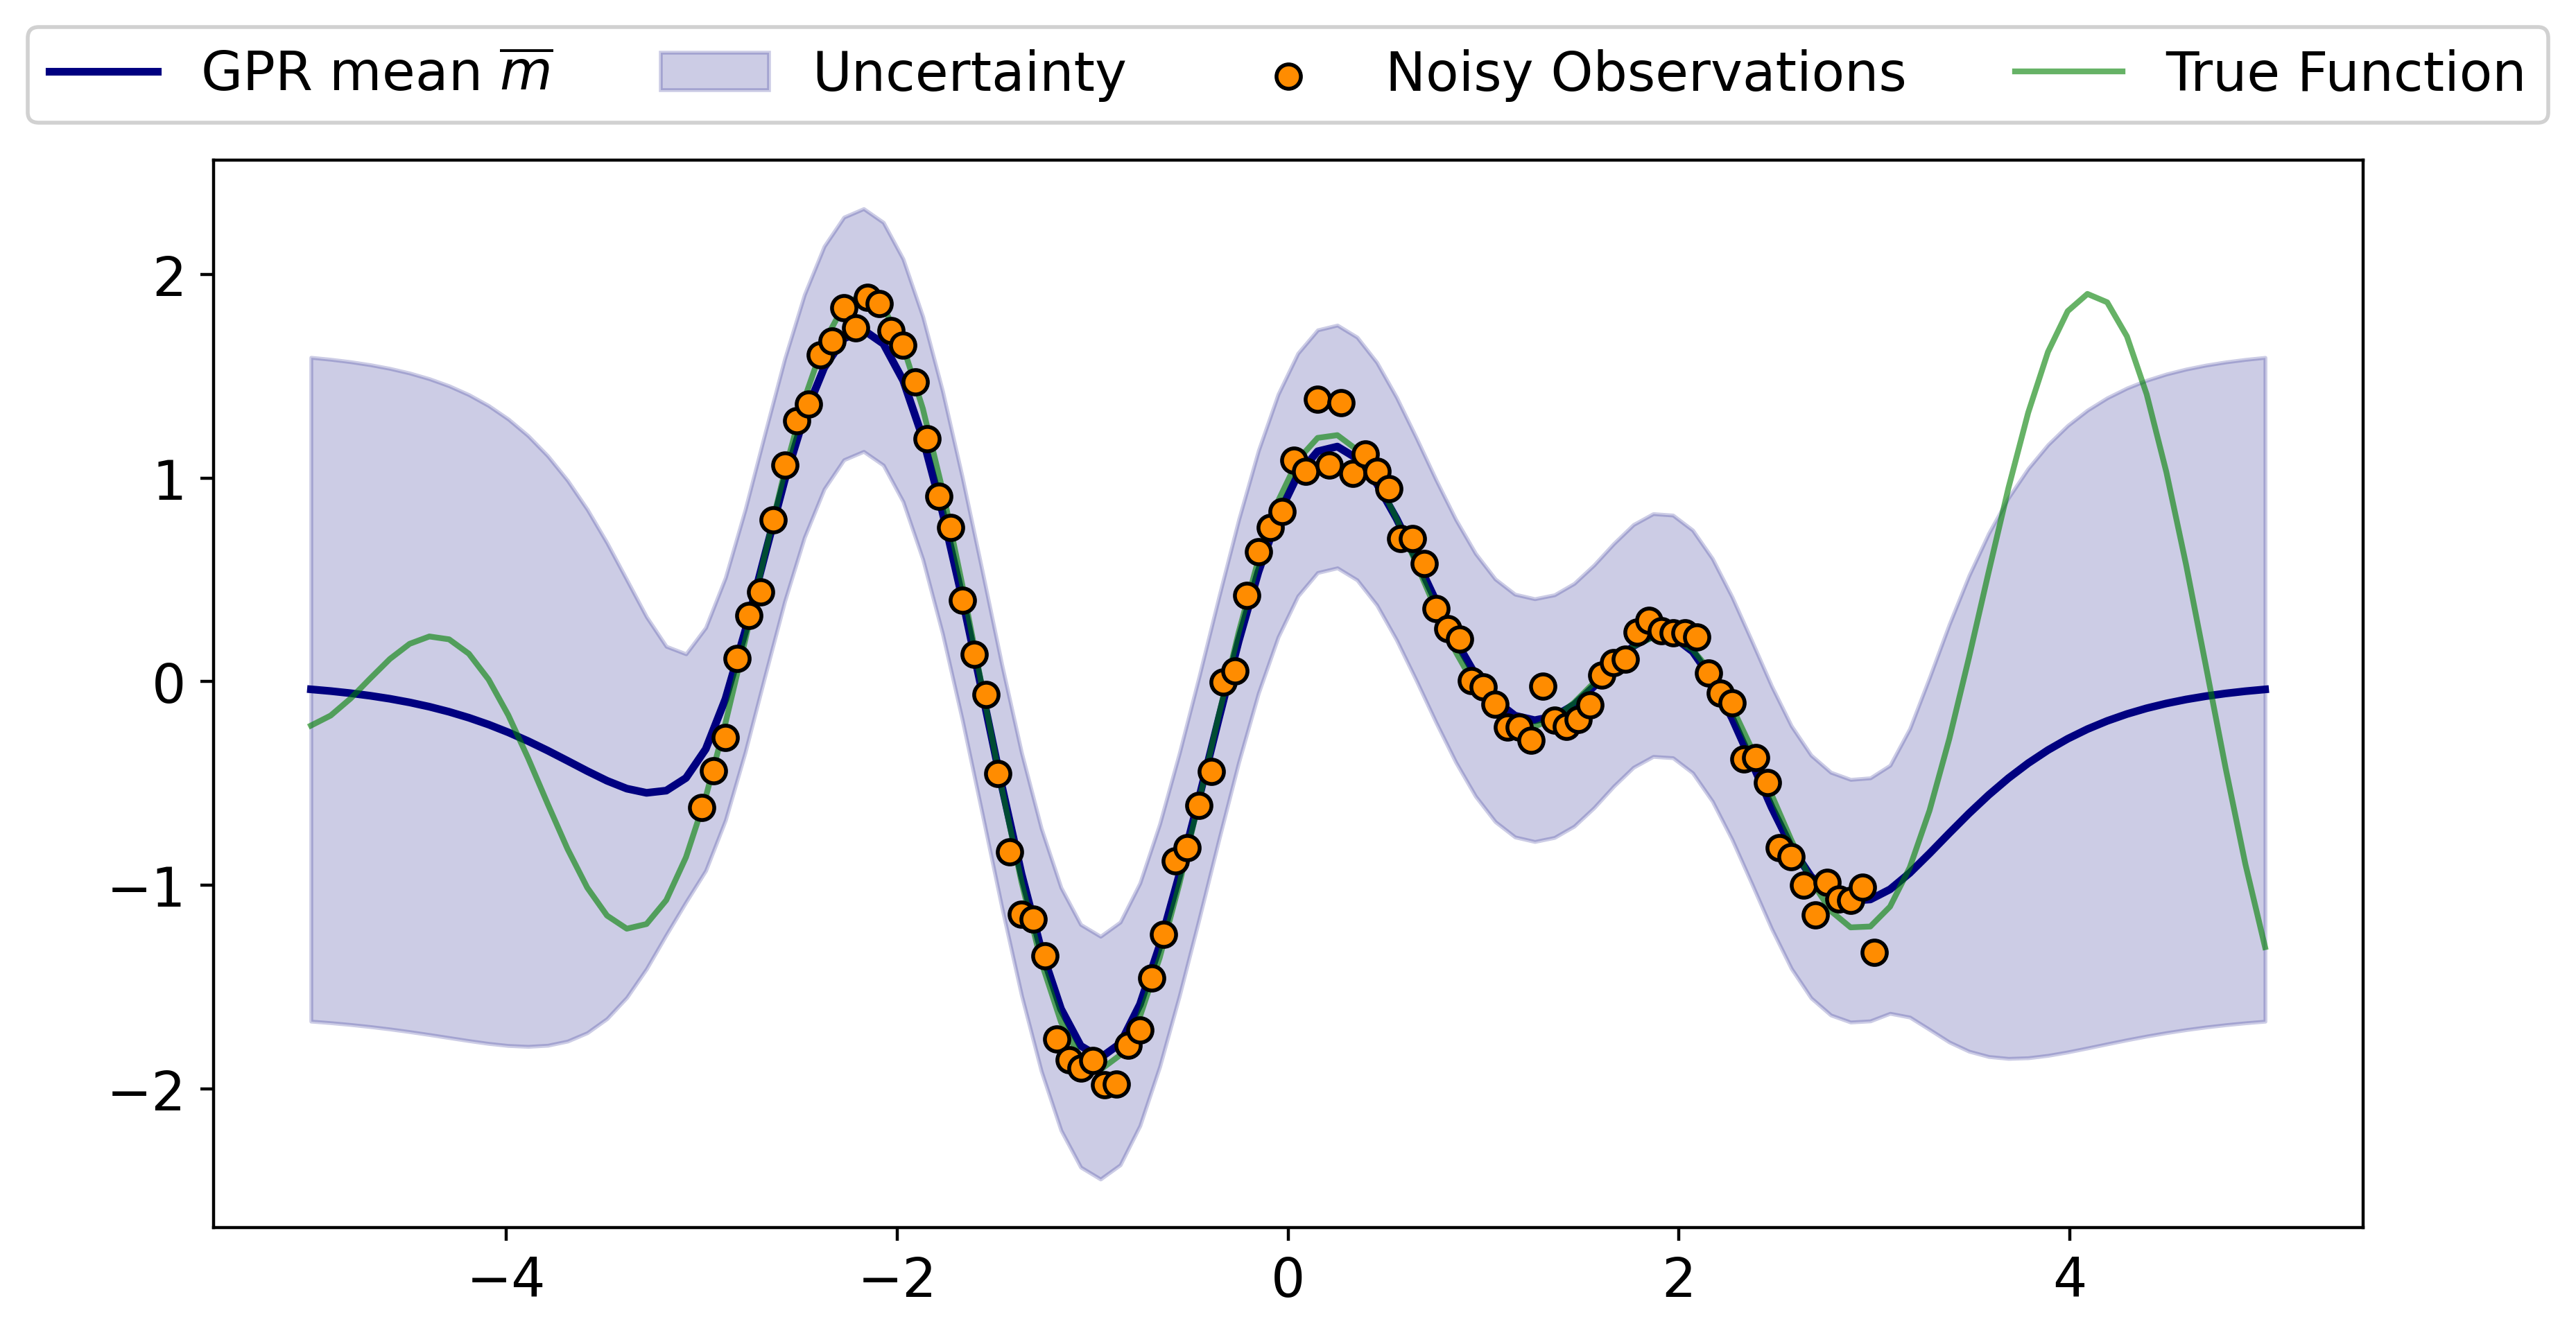

In [3]:

train_x, train_y, test_x, test_y = generate_data(true_function, test_range=(-5, 5), dtype=global_dtype, device=device)
base_kernel = MaternKernel(ard_num_dims=train_x.shape[-1] , lengthscale_prior=GammaPrior(-3.0, 3.0),nu=1.5)

kernel = ScaleKernel(base_kernel, outputscale_prior=GammaPrior(-3.0, 3)).to("cuda:0")
igp = IterativeGaussianProcess(kernel, noise=0.5, dtype=global_dtype, device=device,
                               cg_tol=1e-2, cg_max_iter=10, warm_start=False, num_probes=16,
                               precon_type="identity", trace_backend="Hutch",
                               verbose=False, track_iterations=True,pred_lanczos_rank=train_x.shape[0],precon_rank=5)

igp.fit(train_x, train_y)
mean, covariance,variance = igp.predict(test_x)
std=torch.sqrt(variance)
plot_gp_simple(train_x.cpu(), train_y.cpu(), test_x.cpu(), mean.detach().cpu(), std.detach().cpu(), test_y.cpu())

c:\Users\fredw\chris\Research\randomGP2\code\plotting.py:53: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(GP_mean, GP_covariance, size=num_samples)


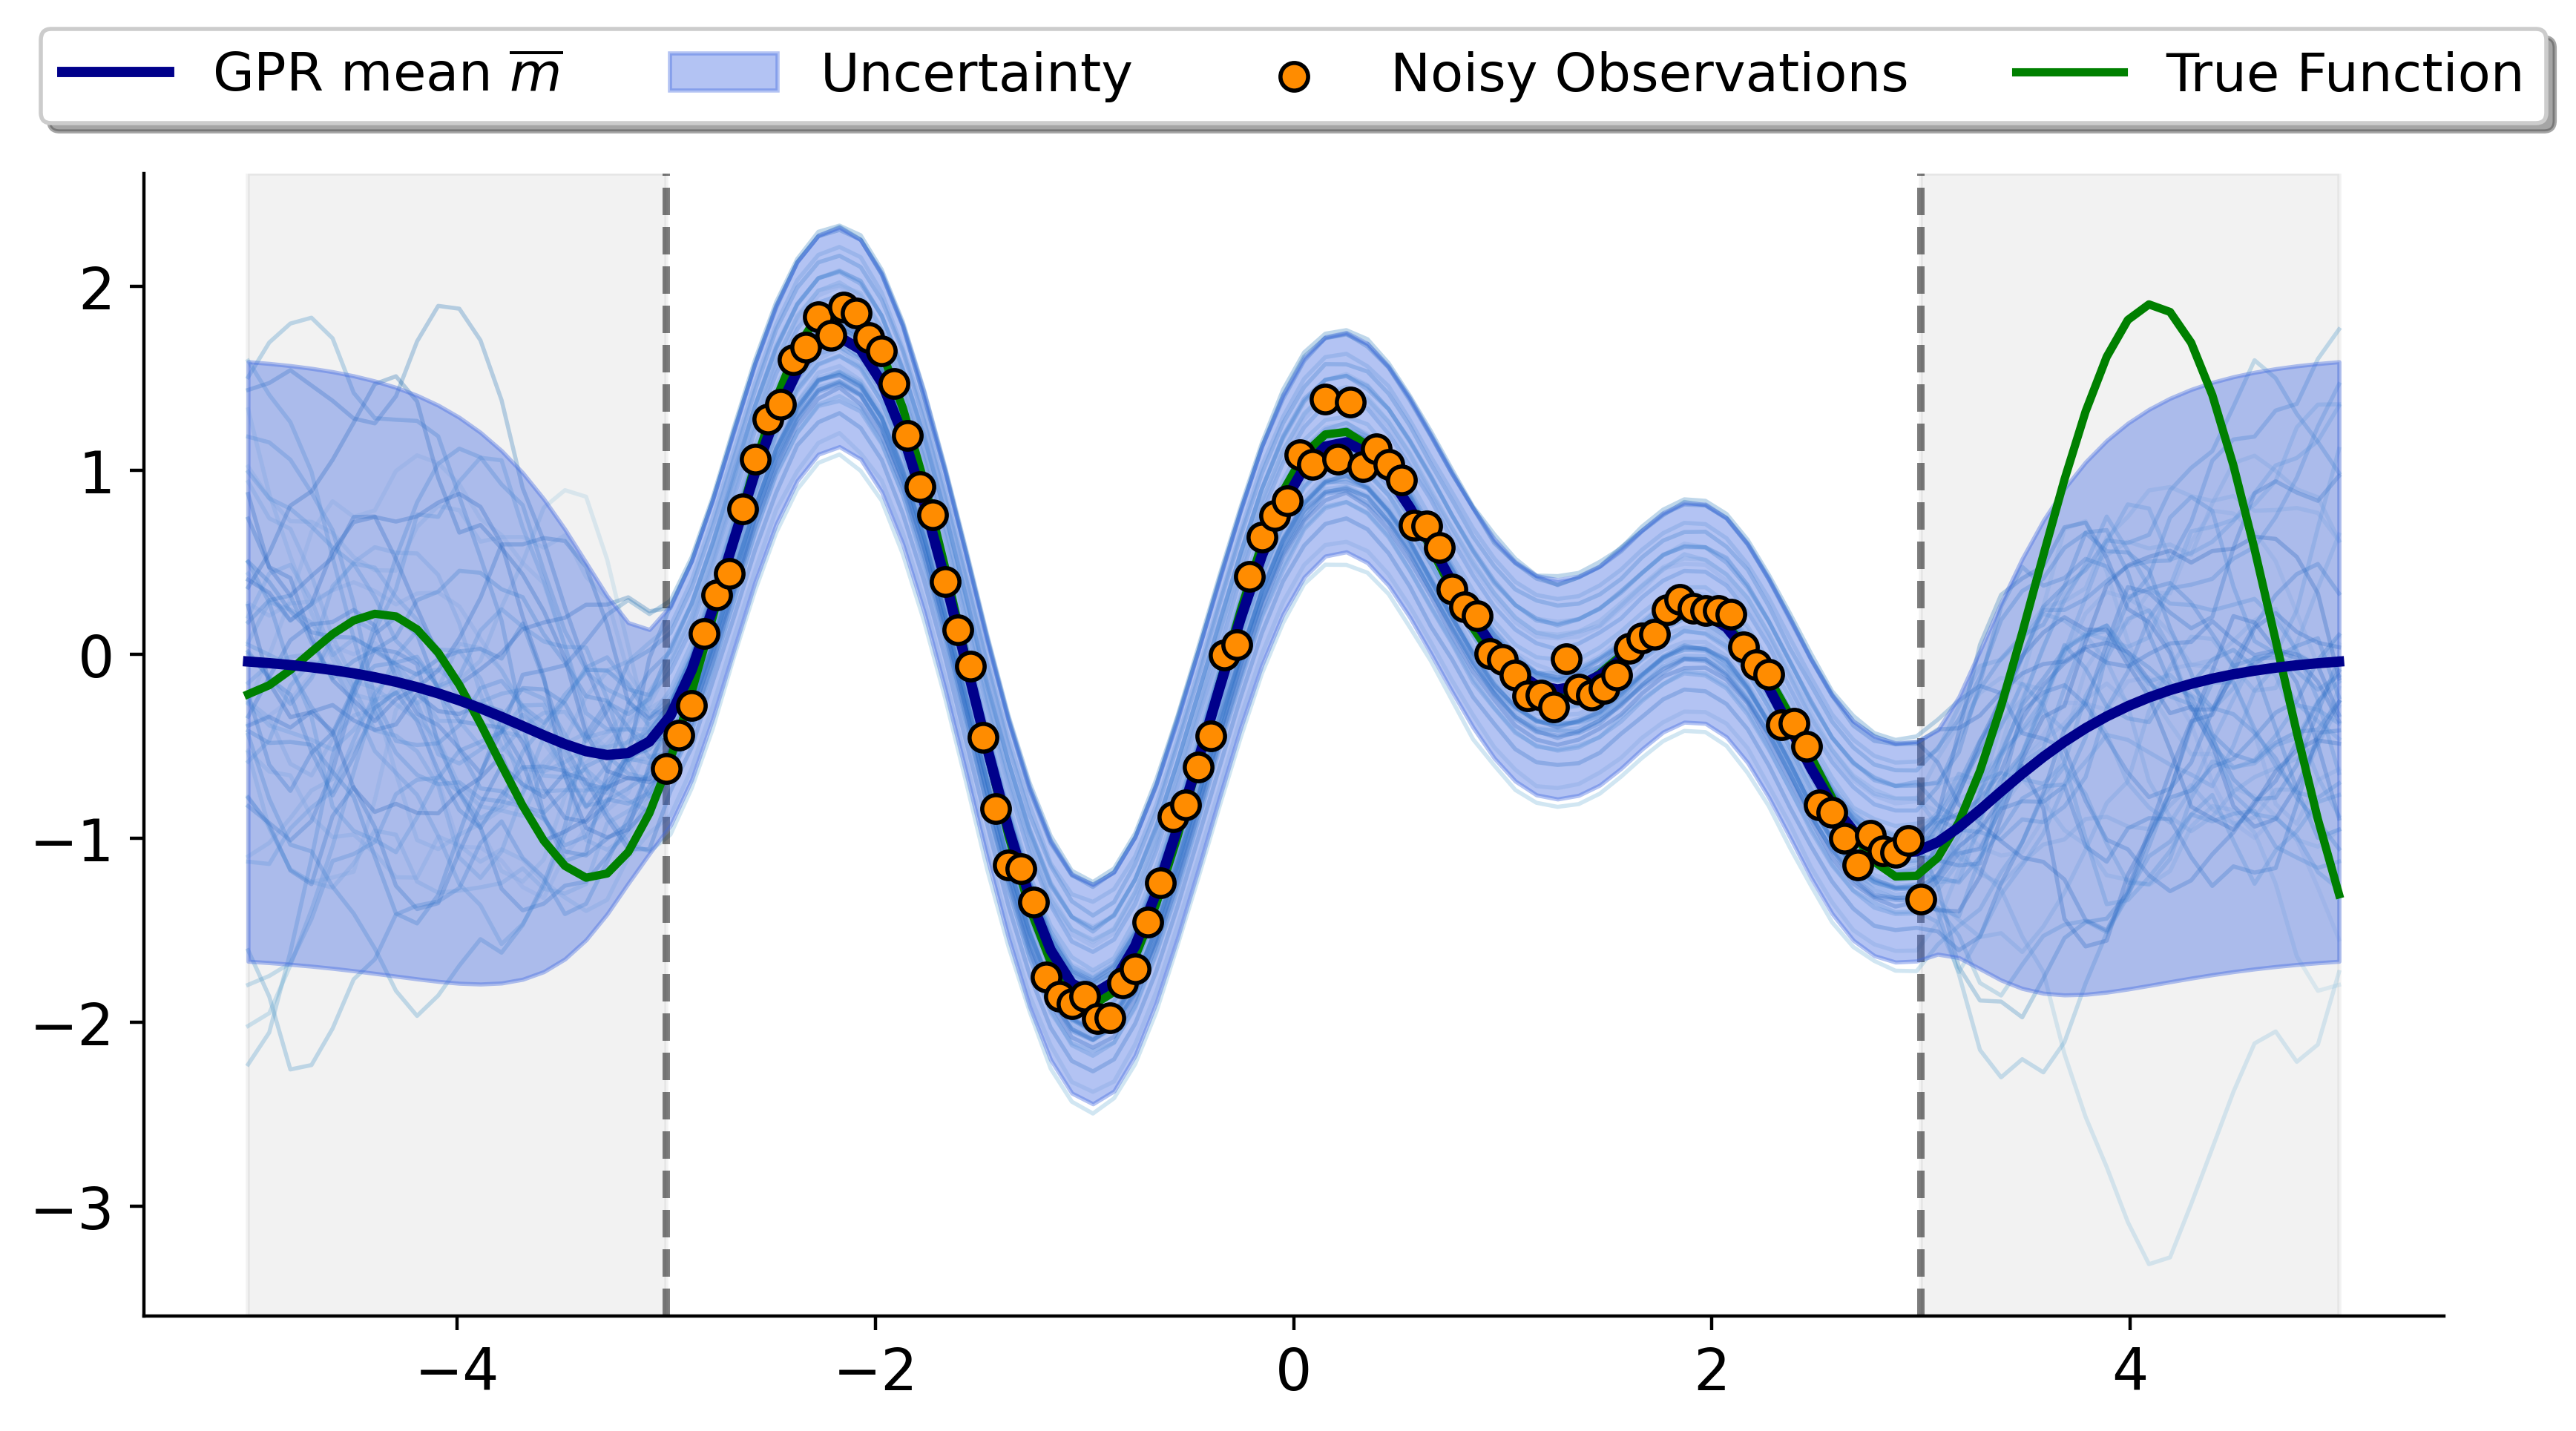

In [4]:
test_x_extended = torch.linspace(-5, 5, 100).to(dtype=train_x.dtype, device="cpu")

plot_gp_sample(
    train_x.cpu(), train_y.cpu(), test_x_extended, test_y.cpu(),
    true_function, mean.detach().cpu(), covariance.detach().cpu(),
    num_samples=45
)

In [8]:
import torch
import gpytorch

# Suppose train_x, train_y, device, global_dtype, etc. are already defined

# 1) Define the kernel
base_kernel = gpytorch.kernels.MaternKernel(
    ard_num_dims=train_x.shape[-1],
    lengthscale_prior=gpytorch.priors.GammaPrior(3.0, 3.0),
    nu=1.5
)
kernel = gpytorch.kernels.ScaleKernel(
    base_kernel,
    outputscale_prior=gpytorch.priors.GammaPrior(3.0, 3.0)
).to(device)

# 2) Define the Iterative GP model with a user-defined class
igp = IterativeGaussianProcess(
    kernel,
    noise=0.5,
    dtype=global_dtype,
    device=device,
    cg_tol=1e-9,
    cg_max_iter=10,
    warm_start=True,
    num_probes=64,  # Hutchinson probes
    precon_type="identity",
    trace_backend="Hutch",
    verbose=False,
    track_iterations=True,
    pred_lanczos_rank=train_x.shape[0],
    precon_rank=5
)

igp.fit(train_x, train_y)

# 3) Compute the MLL in your usual way
mll = igp.compute_mll(train_y)
print("MLL:", mll.item())


MLL: 54.40221405029297


Estimated for raw_outputscale : tensor(-7.8602, device='cuda:0')
True for raw_outputscale : tensor(-7.8033, device='cuda:0')
Estimated for base_kernel.raw_lengthscale : tensor([[8.4805]], device='cuda:0')
True for base_kernel.raw_lengthscale : tensor([[8.3533]], device='cuda:0')
Estimated for noise : tensor(-3.7917, device='cuda:0', grad_fn=<NegBackward0>)
True for noise : tensor(-3.1298)
Relative error for raw_outputscale: 0.007282
Relative error for base_kernel.raw_lengthscale: 0.015224
Relative error for noise: 0.211495


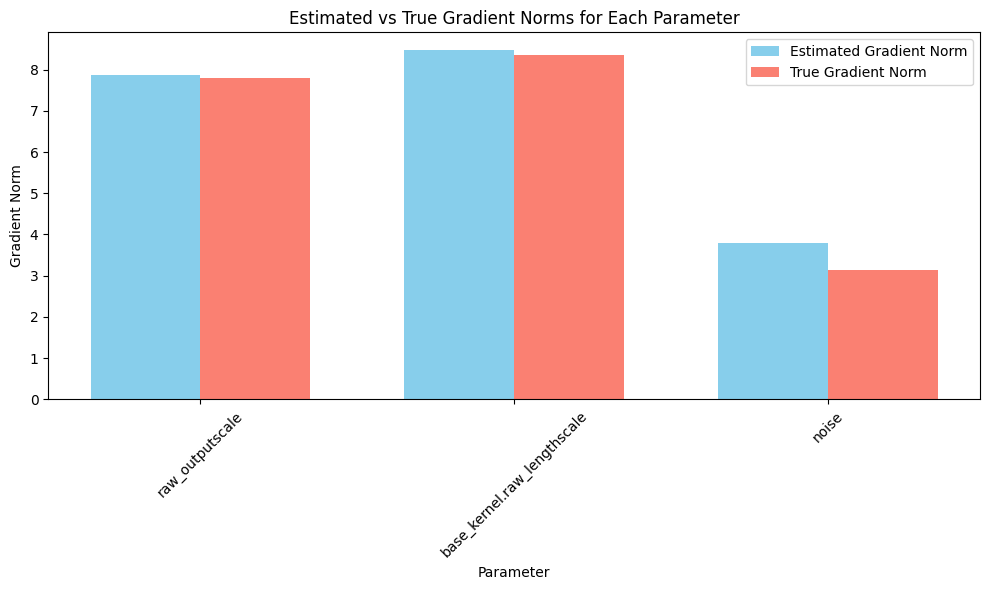

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def estimate_mll_gradient(igp, train_x):
    n = train_x.shape
    u0 = igp.alpha.view(-1, 1)
    U = igp.probe_solutions
    Z = igp.Z
    P_inv = torch.linalg.inv(igp.preconditioner_matrix)
    
    u0_flat = u0.reshape(-1)
    u0_outer = torch.outer(u0_flat, u0_flat)
    P_inv_Z = torch.matmul(P_inv, Z)
    t = Z.shape[1]
    
    outer_products = torch.zeros((t, train_x.shape[0], train_x.shape[0]), device=train_x.device)
    for i in range(t):
        outer_products[i] = torch.outer(P_inv_Z[:, i], U[:, i])
    summed_outer = outer_products.sum(dim=0) / t

    K = igp.kernel(igp.X_train, igp.X_train).to_dense() + (igp.noise.get_value()**2) * torch.eye(train_x.shape[0], device=train_x.device)

    param_grads = {}
    #------- Kernel Params ------- 
    params_list = list(filter(lambda p: p.requires_grad, igp.kernel.parameters()))
    param_names = [name for name, param in igp.kernel.named_parameters() if param.requires_grad]
    
    grads_term1 = torch.autograd.grad(
        K, params_list, grad_outputs=u0_outer, retain_graph=True, create_graph=False
    )
    
    grads_term2 = torch.autograd.grad(
        K, params_list, grad_outputs=summed_outer, retain_graph=True, create_graph=False
    )

    for param_name, grad1, grad2 in zip(param_names, grads_term1, grads_term2):
        param_grads[param_name] = -0.5 * (grad1 + grad2)

    trace_u0 = torch.trace(u0_outer)
    trace_summed = torch.trace(summed_outer)

    noise_value = igp.noise.get_value() 
    noise_u = igp.noise.u
    noise_grad_estimate = noise_value * torch.sigmoid(noise_u) * (trace_u0 + trace_summed)
    param_grads["noise"] =- noise_grad_estimate
    return param_grads

def compute_true_gradients(igp, train_x, train_y, mll):
    kernel = igp.kernel
    noise_param = igp.noise.u

    # Enable gradients for inputs.
    train_x.requires_grad_(True)
    train_y.requires_grad_(True)
    noise_param.requires_grad_(True)
    
    true_grads = {}
    for param_name, param in kernel.named_parameters():
        if param.requires_grad:
            grad = torch.autograd.grad(mll, param, retain_graph=True,allow_unused=True)[0]
            true_grads[param_name] = grad
    
    true_grads["noise"] = torch.autograd.grad(mll, noise_param, retain_graph=True,allow_unused=True)[0]
    return true_grads

def compute_relative_error(estimated_grads, true_grads):
    errors = {}
    for param_name in estimated_grads.keys():
        est = estimated_grads[param_name]
        true = true_grads[param_name]
        print("Estimated for", param_name, ":", est)
        print("True for", param_name, ":", true)
        error = torch.norm(est - true) / torch.norm(true)
        errors[param_name] = error.item()
    return errors

# Assuming igp, train_x, train_y, and mll are defined in your experiment.
estimated_grads = estimate_mll_gradient(igp, train_x)
true_grads = compute_true_gradients(igp, train_x, train_y, mll)
relative_errors = compute_relative_error(estimated_grads, true_grads)

for param_name, error in relative_errors.items():
    print(f"Relative error for {param_name}: {error:.6f}")

# Compute gradient norms for each parameter.
param_names = list(estimated_grads.keys())
est_norms = [torch.norm(estimated_grads[name]).item() for name in param_names]
true_norms = [torch.norm(true_grads[name]).item() for name in param_names]

# Create a grouped bar chart with the gradient norms side by side.
x = np.arange(len(param_names))  # x locations for the groups
width = 0.35  # width of each bar

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, est_norms, width, label='Estimated Gradient Norm', color='skyblue')
plt.bar(x + width/2, true_norms, width, label='True Gradient Norm', color='salmon')
plt.xlabel('Parameter')
plt.ylabel('Gradient Norm')
plt.title('Estimated vs True Gradient Norms for Each Parameter')
plt.xticks(x, param_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
